In [6]:

import os
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


# torch.set_grad_enabled(False)


In [4]:



with open('../data/disease-sympton.txt', 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

diseases = set()
symptoms = set()

disease_sympton = {}
popularity = {} 

for line in lines:
    d, s = line.split(',')[0], line.split(',')[1].split('\n')[0].strip()
    if d!=s:
        diseases.add(d)
        symptoms.add(s)
    
        if s not in popularity.keys():
            popularity[s] = 1
        else:
            popularity[s] += 1
    
        if d not in disease_sympton.keys():
            disease_sympton[d] = set()
            disease_sympton[d].add(s)
        else:
            disease_sympton[d].add(s)

        
popularity = dict(sorted(popularity.items(), key=lambda item: item[1],reverse = True))

print(len(diseases), len(symptoms))
popularity



33 122


{'fatigue': 14,
 'vomiting': 13,
 'high fever': 12,
 'headache': 10,
 'chills': 7,
 'nausea': 7,
 'skin rash': 6,
 'loss of appetite': 6,
 'malaise': 6,
 'itching': 5,
 'chest pain': 5,
 'cough': 5,
 'abdominal pain': 5,
 'diarrhoea': 5,
 'sweating': 5,
 'excessive hunger': 4,
 'lethargy': 4,
 'weight loss': 4,
 'irritability': 4,
 'muscle pain': 4,
 'joint pain': 4,
 'yellowish skin': 3,
 'yellowing of eyes': 3,
 'blurred and distorted vision': 3,
 'breathlessness': 3,
 'dizziness': 3,
 'loss of balance': 3,
 'mild fever': 3,
 'swelled lymph nodes': 3,
 'phlegm': 3,
 'continuous sneezing': 2,
 'acidity': 2,
 'indigestion': 2,
 'restlessness': 2,
 'obesity': 2,
 'family history': 2,
 'stiff neck': 2,
 'depression': 2,
 'neck pain': 2,
 'back pain': 2,
 'dark urine': 2,
 'red spots over body': 2,
 'fast heart rate': 2,
 'mood swings': 2,
 'abnormal menstruation': 2,
 'muscle weakness': 2,
 'swelling joints': 2,
 'painful walking': 2,
 'nodal skin eruptions': 1,
 'dischromic  patches': 1

In [28]:

objects = sorted(list(diseases))  
attrs = sorted(list(symptoms)) 

print(len(objects), len(attrs))

true_fc = torch.zeros(len(objects),len(attrs)).long() 

for i in range(len(objects)):
    for j in range(len(attrs)):
        if attrs[j] in disease_sympton[objects[i]]:
            true_fc[i,j] = 1


df = np.array(true_fc)
df_true = pd.DataFrame(df,columns=attrs, index=pd.Index(objects))


df_true.to_csv('./FC-region-true.csv')






33 122


In [10]:
torch.count_nonzero(true_fc)/(33*122)

tensor(0.0676)

In [24]:

from transformers import BertTokenizer, BertForMaskedLM, AutoTokenizer, AutoModelForMaskedLM
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
# model = BertForMaskedLM.from_pretrained('dmis-lab/biobert-v1.1')

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')


tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')
model = BertForMaskedLM.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')

# tokenizer = BertTokenizer.from_pretrained("Lianglab/PharmBERT-uncased")
# model = BertForMaskedLM.from_pretrained("Lianglab/PharmBERT-uncased")

# tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model = AutoModelForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model.eval()

candidate_objects = objects
candidate_attrs = attrs

attr_ids = []
for attr in candidate_attrs:
  attr_ids.append(tokenizer.convert_tokens_to_ids(attr.lower()))

probs = []
for object in candidate_objects:
  sentence = f"The {tokenizer.mask_token} is a disease that has symptom {object}"
  token_ids = tokenizer.encode(sentence, return_tensors='pt')
  masked_index = token_ids[0].tolist().index(tokenizer.mask_token_id)

  with torch.no_grad():
      outputs = model(token_ids)
      prob = outputs.logits[0, masked_index].softmax(dim=0)[attr_ids]

  probs.append(prob)
    
probs = torch.stack(probs)
probs


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/workspace/anaconda3/envs/llm/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use te

tensor([[2.8406e-06, 2.8406e-06, 4.6479e-07,  ..., 2.8406e-06, 2.8406e-06,
         2.8406e-06],
        [3.2674e-06, 3.2674e-06, 3.8647e-07,  ..., 3.2674e-06, 3.2674e-06,
         3.2674e-06],
        [3.1531e-06, 3.1531e-06, 5.3214e-07,  ..., 3.1531e-06, 3.1531e-06,
         3.1531e-06],
        ...,
        [6.4721e-07, 6.4721e-07, 3.9355e-07,  ..., 6.4721e-07, 6.4721e-07,
         6.4721e-07],
        [5.7858e-06, 5.7858e-06, 6.6077e-07,  ..., 5.7858e-06, 5.7858e-06,
         5.7858e-06],
        [5.1275e-06, 5.1275e-06, 6.1856e-07,  ..., 5.1275e-06, 5.1275e-06,
         5.1275e-06]])

In [15]:

# prob

tensor([3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 2.0992e-04,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 7.4341e-05, 2.2566e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 1.8306e-04, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.8252e-04,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 2.7559e-05, 3.0047e-05, 4.9067e-04,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05, 3.0047e-05,
        6.4917e-05, 3.0047e-05, 3.0047e-05, 1.9915e-05, 3.0047e-05, 3.0047e-05,
        3.0047e-05, 3.0047e-05, 3.0047e-

In [61]:
set(attr_ids)

{3147, 8387, 14671, 15877, 18583, 19132, 26180, 26287, 27641, 28246, 28389}

In [146]:


# logprob = torch.log(probs)
# print(logprob)
# # for i in range(len(probs)):
# outmap_min = logprob.min().item()
# outmap_max = logprob.max().item()
# logprob_normalized = (logprob - outmap_min) / (outmap_max - outmap_min)
# logprob_normalized


tensor([[ -9.6320, -10.9588,  -8.3504,  ..., -16.5488, -16.5488, -11.8952],
        [-14.4719,  -8.3923, -11.3739,  ..., -20.3387, -20.3387, -13.3462],
        [ -7.1533,  -5.9514,  -5.7768,  ..., -14.1002, -14.1002,  -6.0607],
        ...,
        [ -9.6776,  -5.8961,  -7.7533,  ..., -13.2365, -13.2365,  -9.3563],
        [-10.2340,  -7.0894,  -8.3837,  ..., -15.6854, -15.6854, -12.1612],
        [-10.5431,  -3.4525,  -7.7585,  ..., -15.8291, -15.8291, -12.5161]])


tensor([[0.5299, 0.4643, 0.5934,  ..., 0.1876, 0.1876, 0.4179],
        [0.2904, 0.5913, 0.4437,  ..., 0.0000, 0.0000, 0.3461],
        [0.6526, 0.7121, 0.7207,  ..., 0.3088, 0.3088, 0.7067],
        ...,
        [0.5277, 0.7148, 0.6229,  ..., 0.3515, 0.3515, 0.5436],
        [0.5001, 0.6558, 0.5917,  ..., 0.2303, 0.2303, 0.4047],
        [0.4848, 0.8358, 0.6226,  ..., 0.2232, 0.2232, 0.3872]])

In [149]:


# print( [attrs[i] for i in torch.topk(probs[objects.index('chest pain')],3).indices.tolist() ])
# print( [attrs[i] for i in torch.topk(probs[objects.index('high fever')],3).indices.tolist() ])
# print( [attrs[i] for i in torch.topk(probs[objects.index('skin peeling')],3).indices.tolist() ])


['Pneumonia', 'Asthma', 'Tuberculosis']
['Pneumonia', 'Tuberculosis', 'Malaria']
['Tuberculosis', 'Pneumonia', 'Arthritis']


In [110]:
# popularity

In [26]:





df = np.array(probs)
df = pd.DataFrame(df,columns=attrs, index=pd.Index(objects))

# df[0:50][['French','English']]
# def get_ranking(df,truth):

def hit_k(df, truth, k):

    total_pair = 0
    hits = 0

    for ind in df.index:
        keys = df.loc[ind].keys()
        values = df.loc[ind].values
        topk = values.argsort()[-k:][::-1]

        for attr in truth[ind]:
            if attr in set(keys[topk].tolist()):
                hits += 1

            
            total_pair += 1
    # print(total_pair)
    return hits/total_pair


def mean_rank(df, truth):
    
    reciprocal_rank = 0
    count = 0
    for country in df.index:
        keys = df.loc[country].keys()
        values = df.loc[country].values
        rank = values.argsort()[::-1]
        
        for lang in truth[country]:
            if lang in keys.tolist():
                reciprocal_rank = reciprocal_rank + (1/ (rank.tolist().index(keys.tolist().index(lang))+1) )
                count +=1

    return reciprocal_rank/count



hit_k(df, disease_sympton, 1), hit_k(df, disease_sympton, 5), hit_k(df, disease_sympton, 10), mean_rank(df, disease_sympton)




(0.029411764705882353,
 0.09926470588235294,
 0.19852941176470587,
 0.0867185771823454)

In [29]:



from sklearn.metrics import f1_score,average_precision_score

# stacked_tensors = torch.stack([probs_a,probs_b,probs_c], dim=0)

# probs_max = torch.max(stacked_tensors, dim=0)[0]

# for i in range(len(probs)):
outmap_min = probs.min().item()
outmap_max = probs.max().item()
logprob_normalized = (probs - outmap_min) / (outmap_max - outmap_min)

df_normalized = np.array(logprob_normalized)
df_normalized = pd.DataFrame(df_normalized,columns=attrs, index=pd.Index(objects))
df_normalized = df_normalized.round(0).astype(float)

df_normalized

f1 = f1_score(y_true=df_true.astype(int).values, y_pred=df_normalized.astype(int).values,average="weighted" )
mAP = average_precision_score(df_true.astype(int).values, df_normalized.astype(int).values)
f1, mAP



(0.014037433155080214, 0.0758320914058619)

In [106]:
# BERT (0.022058823529411766,0.11029411764705882,0.1801470588235294,0.07525182194439548)


# # The {tokenizer.mask_token} is a disease that has symptom: {object}
# BERT (0.01838235294117647, 0.05514705882352941, 0.13602941176470587, 0.06200592635349528)
# BiomedBERT (0.04779411764705882, 0.18382352941176472, 0.2610294117647059, 0.12166081650571424)
# PharmBERT_uncased (0.022058823529411766,0.08455882352941177,0.14705882352941177,0.0707547902344547)
# (0.03636363636363636, 0.1, 0.18181818181818182, 0.08973229718822276)
# (0.06363636363636363, 0.22727272727272727, 0.32727272727272727, 0.15194506271911623)
# (0.045454545454545456, 0.17272727272727273, 0.2545454545454545,0.11831106567622691)
# # The {object} is a sympton of the disease: {tokenizer.mask_token}
# (0.007352941176470588, 0.05514705882352941,0.10661764705882353,0.04992782245252902)
# (0.022058823529411766,0.10294117647058823,0.1801470588235294,0.08031496761501707)
# (0.01838235294117647, 0.08455882352941177, 0.14705882352941177,0.06659751687014943)
# # new attr 1
# (0.03636363636363636, 0.1, 0.18181818181818182, 0.08973229718822276)
# (0.06363636363636363, 0.22727272727272727, 0.32727272727272727, 0.15194506271911623)
# (0.045454545454545456, 0.17272727272727273, 0.2545454545454545,0.11831106567622691)

In [116]:
probs.shape

torch.Size([15, 11])

In [123]:



logprob = torch.log(probs)
# print(logprob)
# for i in range(len(probs)):
outmap_min = logprob.min().item()
outmap_max = logprob.max().item()
logprob_normalized = (logprob - outmap_min) / (outmap_max - outmap_min)

logprob_normalized



tensor([[0.3862, 0.4979, 0.5423, 0.3180, 0.6386, 0.3703, 0.2881, 0.1365, 0.1650,
         0.5188, 0.0881],
        [0.3481, 0.3139, 0.8632, 0.5171, 0.4789, 0.1063, 0.0966, 0.1708, 0.4827,
         0.5934, 0.1984],
        [0.3067, 0.6280, 0.4918, 1.0000, 0.4226, 0.5106, 0.5713, 0.4004, 0.3067,
         0.4414, 0.4591],
        [0.4856, 0.4360, 0.9528, 0.6910, 0.4980, 0.2758, 0.4063, 0.2788, 0.7608,
         0.7939, 0.4460],
        [0.5048, 0.3892, 0.4939, 0.4524, 0.5518, 0.4832, 0.7105, 0.2593, 0.4172,
         0.5544, 0.1786],
        [0.4508, 0.5636, 0.5909, 0.4629, 0.7841, 0.4636, 0.4345, 0.3052, 0.2366,
         0.4082, 0.2990],
        [0.2025, 0.4266, 0.5790, 0.3534, 0.5517, 0.1473, 0.2783, 0.2796, 0.1737,
         0.3031, 0.6070],
        [0.5335, 0.6263, 0.6714, 0.6515, 0.5715, 0.6172, 0.8291, 0.2853, 0.5975,
         0.7563, 0.3565],
        [0.1929, 0.4765, 0.5589, 0.5241, 0.3096, 0.2358, 0.2938, 0.0483, 0.0000,
         0.2055, 0.0647],
        [0.6411, 0.5514, 0.5813, 0.49

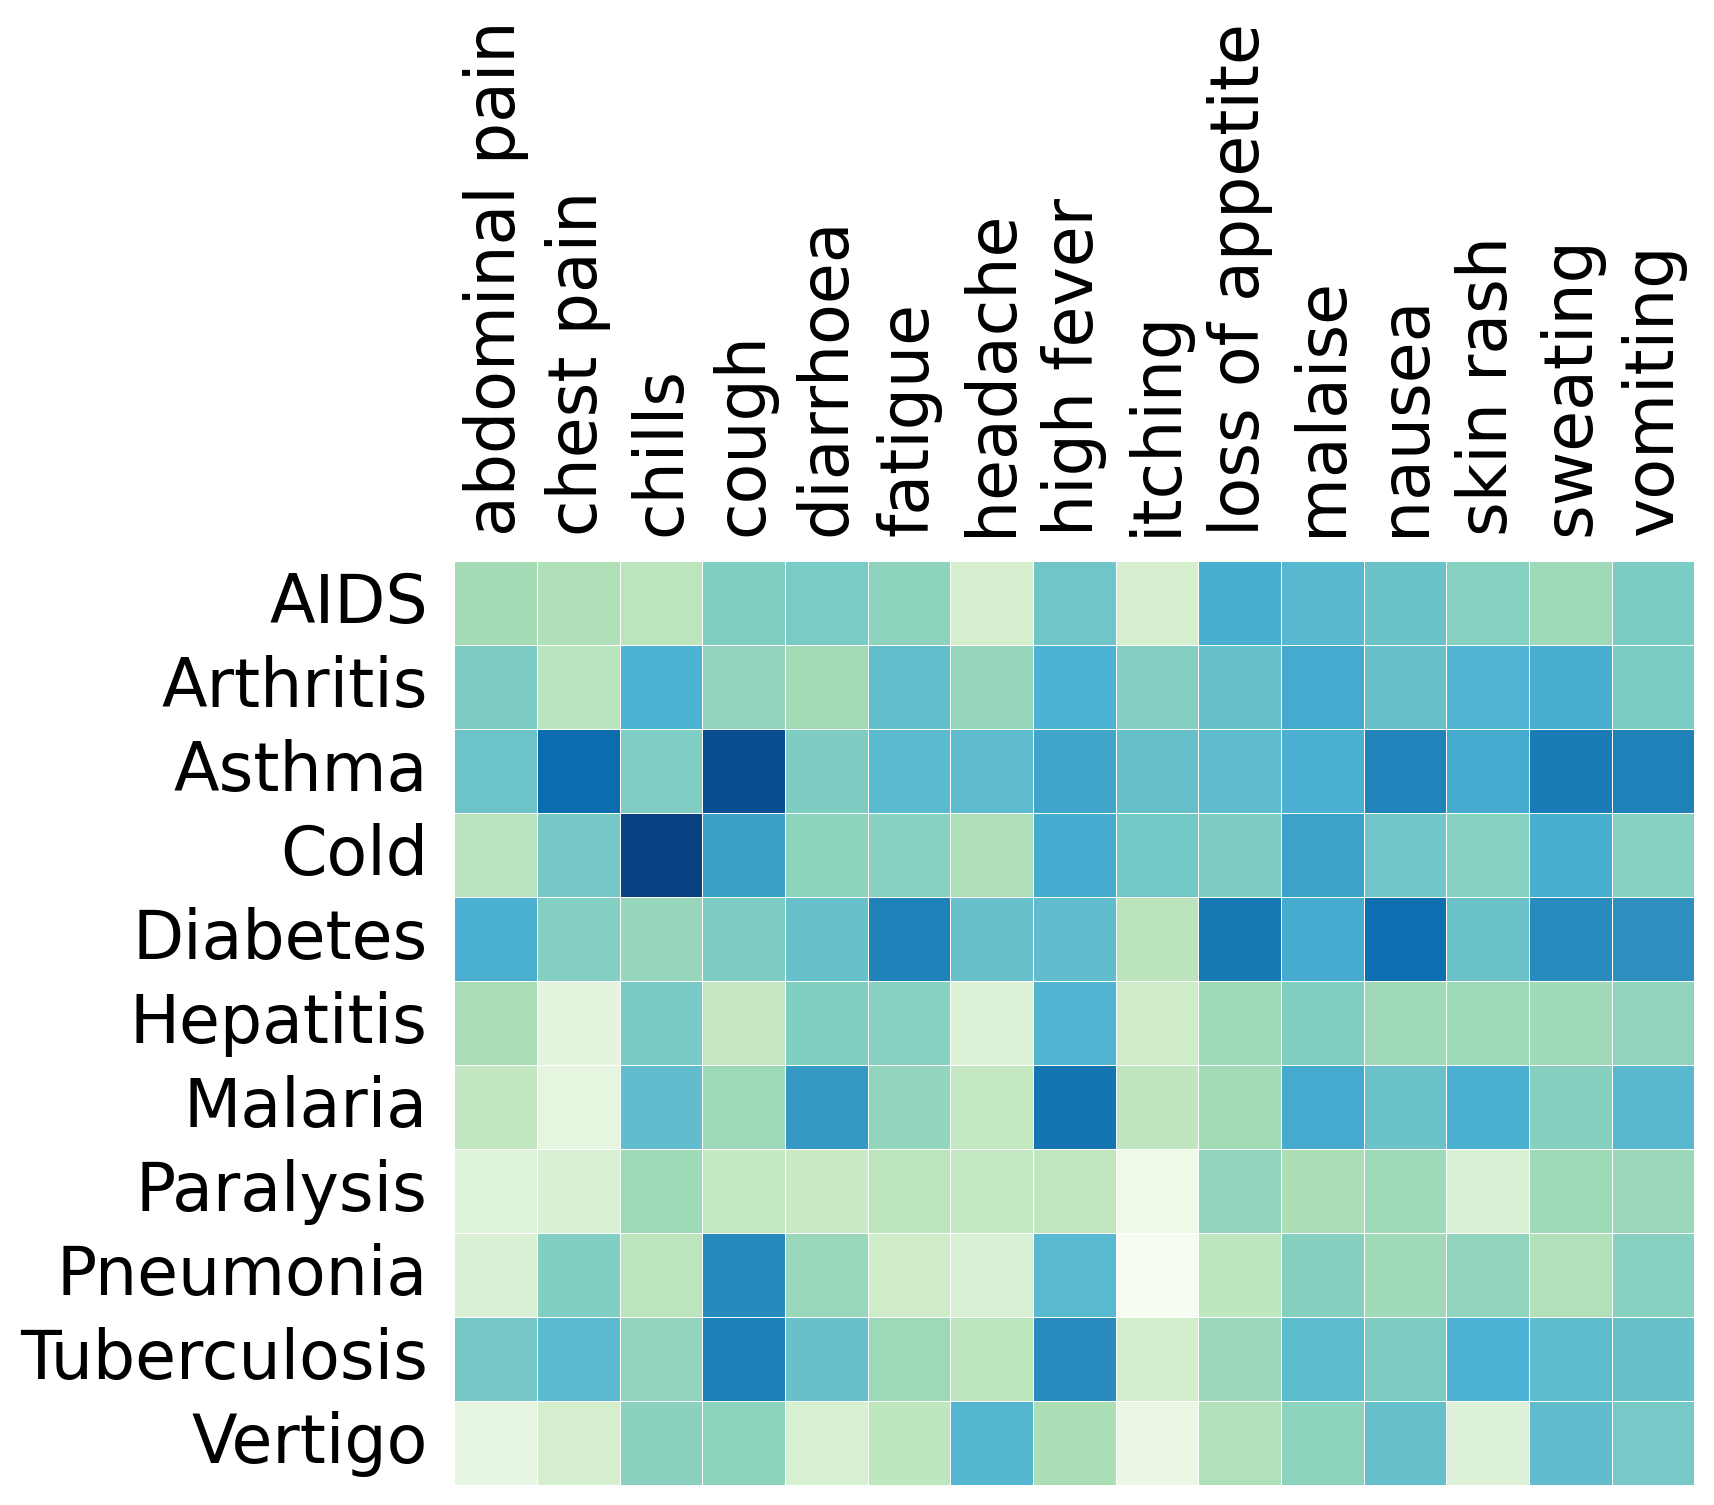

In [130]:







import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=200)

meta_r = 0

df = np.array(logprob_normalized.t())
inds = [' '.join(ind.split(' ')[0:3]) if len(ind.split(' '))>=4 else ind for ind in new_objects]
df = pd.DataFrame(df,columns=inds, index=pd.Index(new_attrs))

sns.set(font_scale=1.)

x_axis_labels = new_objects
y_axis_labels = new_attrs


ax = sns.heatmap(df, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False, linewidth=0.2, cmap='GnBu', square=False, annot= False )

plt.tick_params(axis='y', which='major', colors='black', labelsize=24, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(axis='x', which='major', colors='black', rotation=90, labelsize=24, labelbottom = False, bottom=False, top = False, labeltop=True)


plt.savefig('Full-softmax-disease-sympton.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)


plt.show()









In [76]:


# x1 = (0.01838235294117647, 0.05514705882352941, 0.13602941176470587, 0.06200592635349528)
# x2 = (0.04779411764705882, 0.18382352941176472, 0.2610294117647059, 0.12166081650571424)
# x3 =  (0.022058823529411766,0.08455882352941177,0.14705882352941177,0.0707547902344547)
# y1 = (0.03636363636363636, 0.1, 0.18181818181818182, 0.08973229718822276)
# y2 = (0.06363636363636363, 0.22727272727272727, 0.32727272727272727, 0.15194506271911623)
# y3 = (0.045454545454545456, 0.17272727272727273, 0.2545454545454545,0.11831106567622691)


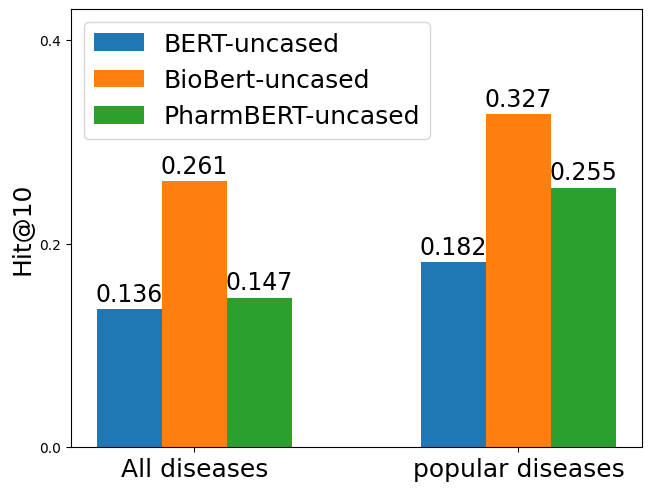

In [103]:


import matplotlib.pyplot as plt
import numpy as np

species = ("All diseases", "popular diseases")
penguin_means = {
    'BERT-uncased': (0.136, 0.182),
    'BioBert-uncased': (0.261, 0.327),
    'PharmBERT-uncased': (0.147, 0.255),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2,fontsize=17)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Hit@10',fontsize=18)
# ax.set_title('Penguin attributes by species')
ax.set_yticks([0,0.2,0.4])
plt.xticks(fontsize=18)
ax.set_xticks(x + width, species,fontsize=18)
ax.legend(loc='upper left',fontsize=18)
ax.set_ylim(0, 0.43)

plt.savefig('DiseaseSymptom.pdf', bbox_inches='tight', pad_inches=0, dpi=200)


plt.show()


In [16]:
# import numpy as np
# from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(df.values)
# X_embedded.shape


/tmp/ipykernel_2423319/2438721968.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df["German"][i]-0.02, df["French"][i]), fontsize=16)


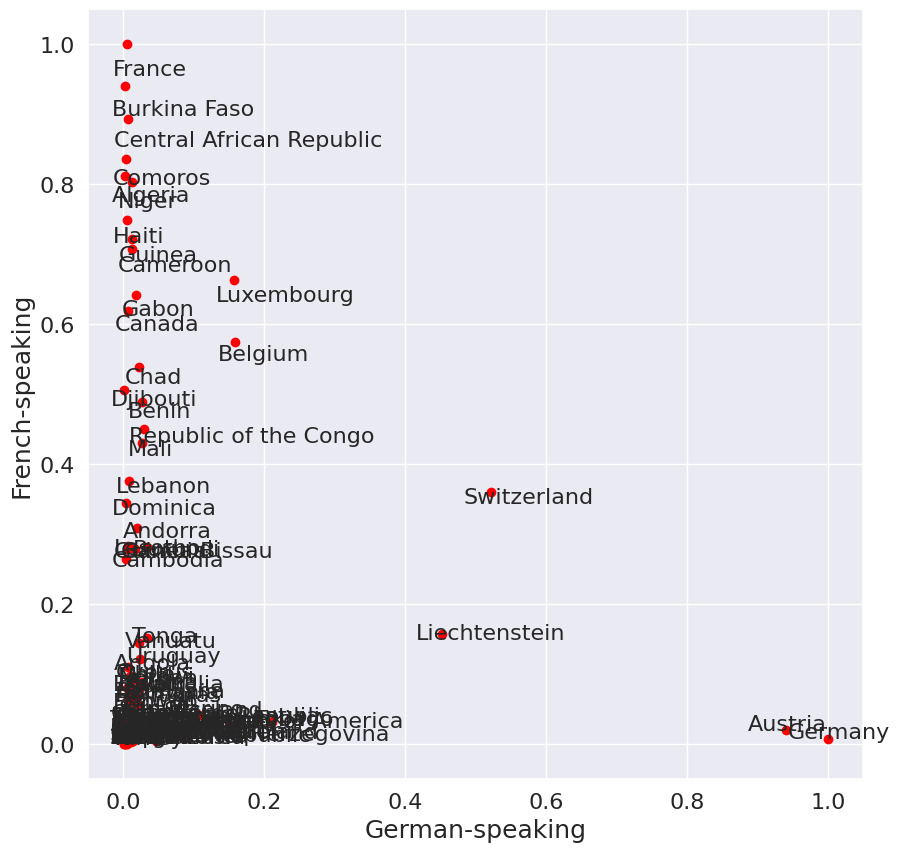

In [113]:

df = np.array(probs)
df = pd.DataFrame(df,columns=attrs, index=pd.Index(objects))

# normalized_df = (df-df.min())/(df.max()-df.min())

plt.figure(figsize=(10, 10), dpi=100)

x = (df["German"] - df["German"].min()) / ( df["German"].max() - df["German"].min())
y = (df["French"] - df["French"].min()) / ( df["French"].max() - df["French"].min())


plt.scatter(x, y, c='red')

for i, txt in enumerate(df.index.tolist()):
    plt.annotate(txt, (df["German"][i]-0.02, df["French"][i]), fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel("German-speaking", fontsize=18)
plt.ylabel("French-speaking", fontsize=18)


plt.show()


In [106]:

# pip install plotly==4.1.1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:010m
Note: you may need to restart the kernel to use updated packages.


In [114]:


# sm = torch.nn.Softmax(dim=0)
# sig = torch.nn.Sigmoid()
# torch.set_grad_enabled(False)

# from transformers import BertTokenizer, BertForMaskedLM
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# # tokenizer = AutoTokenizer.from_pretrained('veroman/TourBERT')
# # model = AutoModelForMaskedLM.from_pretrained('veroman/TourBERT')

# model.eval()

# candidate_objects = ['america','germany','france','belgium','china']

# candidate_attributes = ['english','german', 'french','chinese']
# attr_ids = []
# for attr in candidate_attributes:
#   attr_ids.append(tokenizer.convert_tokens_to_ids(attr))


# # probs = []
# # for object in candidate_objects:

# sentence = f"{tokenizer.mask_token} is the official language in Japan"
# token_ids = tokenizer.encode(sentence, return_tensors='pt')
# masked_index = token_ids[0].tolist().index(tokenizer.mask_token_id)

# with torch.no_grad():
#   outputs = model(token_ids)
#   prob = outputs.logits[0, masked_index] #.softmax(dim=0)[attr_ids]

# top_k = 5
# top_predictions = torch.topk(prob, top_k)
# for i in range(top_k):
#     token_index = top_predictions.indices[i].item()
#     token_prob = top_predictions.values[i].item()
#     predicted_token = tokenizer.convert_ids_to_tokens(token_index)
#     print(f"{predicted_token}: {token_prob}")
    
# # probs.append(prob)

# # probs = torch.stack(probs).t()
# # probs





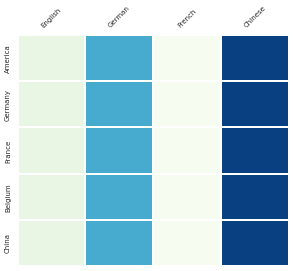

In [36]:






import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6), dpi=50)

meta_r = 0

df = np.array(probs)
df = pd.DataFrame(df)


sns.set(font_scale=1.)

x_axis_labels = candidate_attribute
y_axis_labels = candidate_tokens


ax = sns.heatmap(df, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False, linewidth=0.5, cmap='GnBu', square=False, annot= False )

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(axis='x', which='major', rotation=45, labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)


# plt.savefig('FC.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)


plt.show()







In [37]:

probs

tensor([[9.7193e-07, 1.9009e-06, 8.4134e-07, 2.4666e-06],
        [9.7193e-07, 1.9009e-06, 8.4134e-07, 2.4666e-06],
        [9.7193e-07, 1.9009e-06, 8.4134e-07, 2.4666e-06],
        [9.7193e-07, 1.9009e-06, 8.4134e-07, 2.4666e-06],
        [9.7193e-07, 1.9009e-06, 8.4134e-07, 2.4666e-06]])